In [1]:
import numpy as np
import proplot as pplt
import sxdes
import fitsio
import os
import subprocess
import copy

from ngmix.medsreaders import NGMixMEDS

In [3]:
with fitsio.FITS("data/DES0000+0209_r5932p01_r_pizza-cutter-slices.fits.fz") as ft:
    print(ft)


  file: data/DES0000+0209_r5932p01_r_pizza-cutter-slices.fits.fz
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      IMAGE_HDU       image_cutouts
  2      IMAGE_HDU       weight_cutouts
  3      IMAGE_HDU       seg_cutouts
  4      IMAGE_HDU       bmask_cutouts
  5      IMAGE_HDU       ormask_cutouts
  6      IMAGE_HDU       noise_cutouts
  7      IMAGE_HDU       mfrac_cutouts
  8      IMAGE_HDU       psf
  9      BINARY_TBL      object_data
  10     BINARY_TBL      epochs_info
  11     BINARY_TBL      metadata
  12     IMAGE_HDU       tile_info
  13     BINARY_TBL      image_info
  14     BINARY_TBL      gaia_stars


In [4]:
img = fitsio.read("data/DES0000+0209_r5932p01_r_pizza-cutter-slices-coadd-img.fits.fz")
d = fitsio.read("mdet_data/DES0000+0209_metadetect-v8_mdetcat_part0000.fits")
gs = fitsio.read("data/DES0000+0209_r5932p01_r_pizza-cutter-slices.fits.fz", ext="gaia_stars")

(0.0, 1000.0)

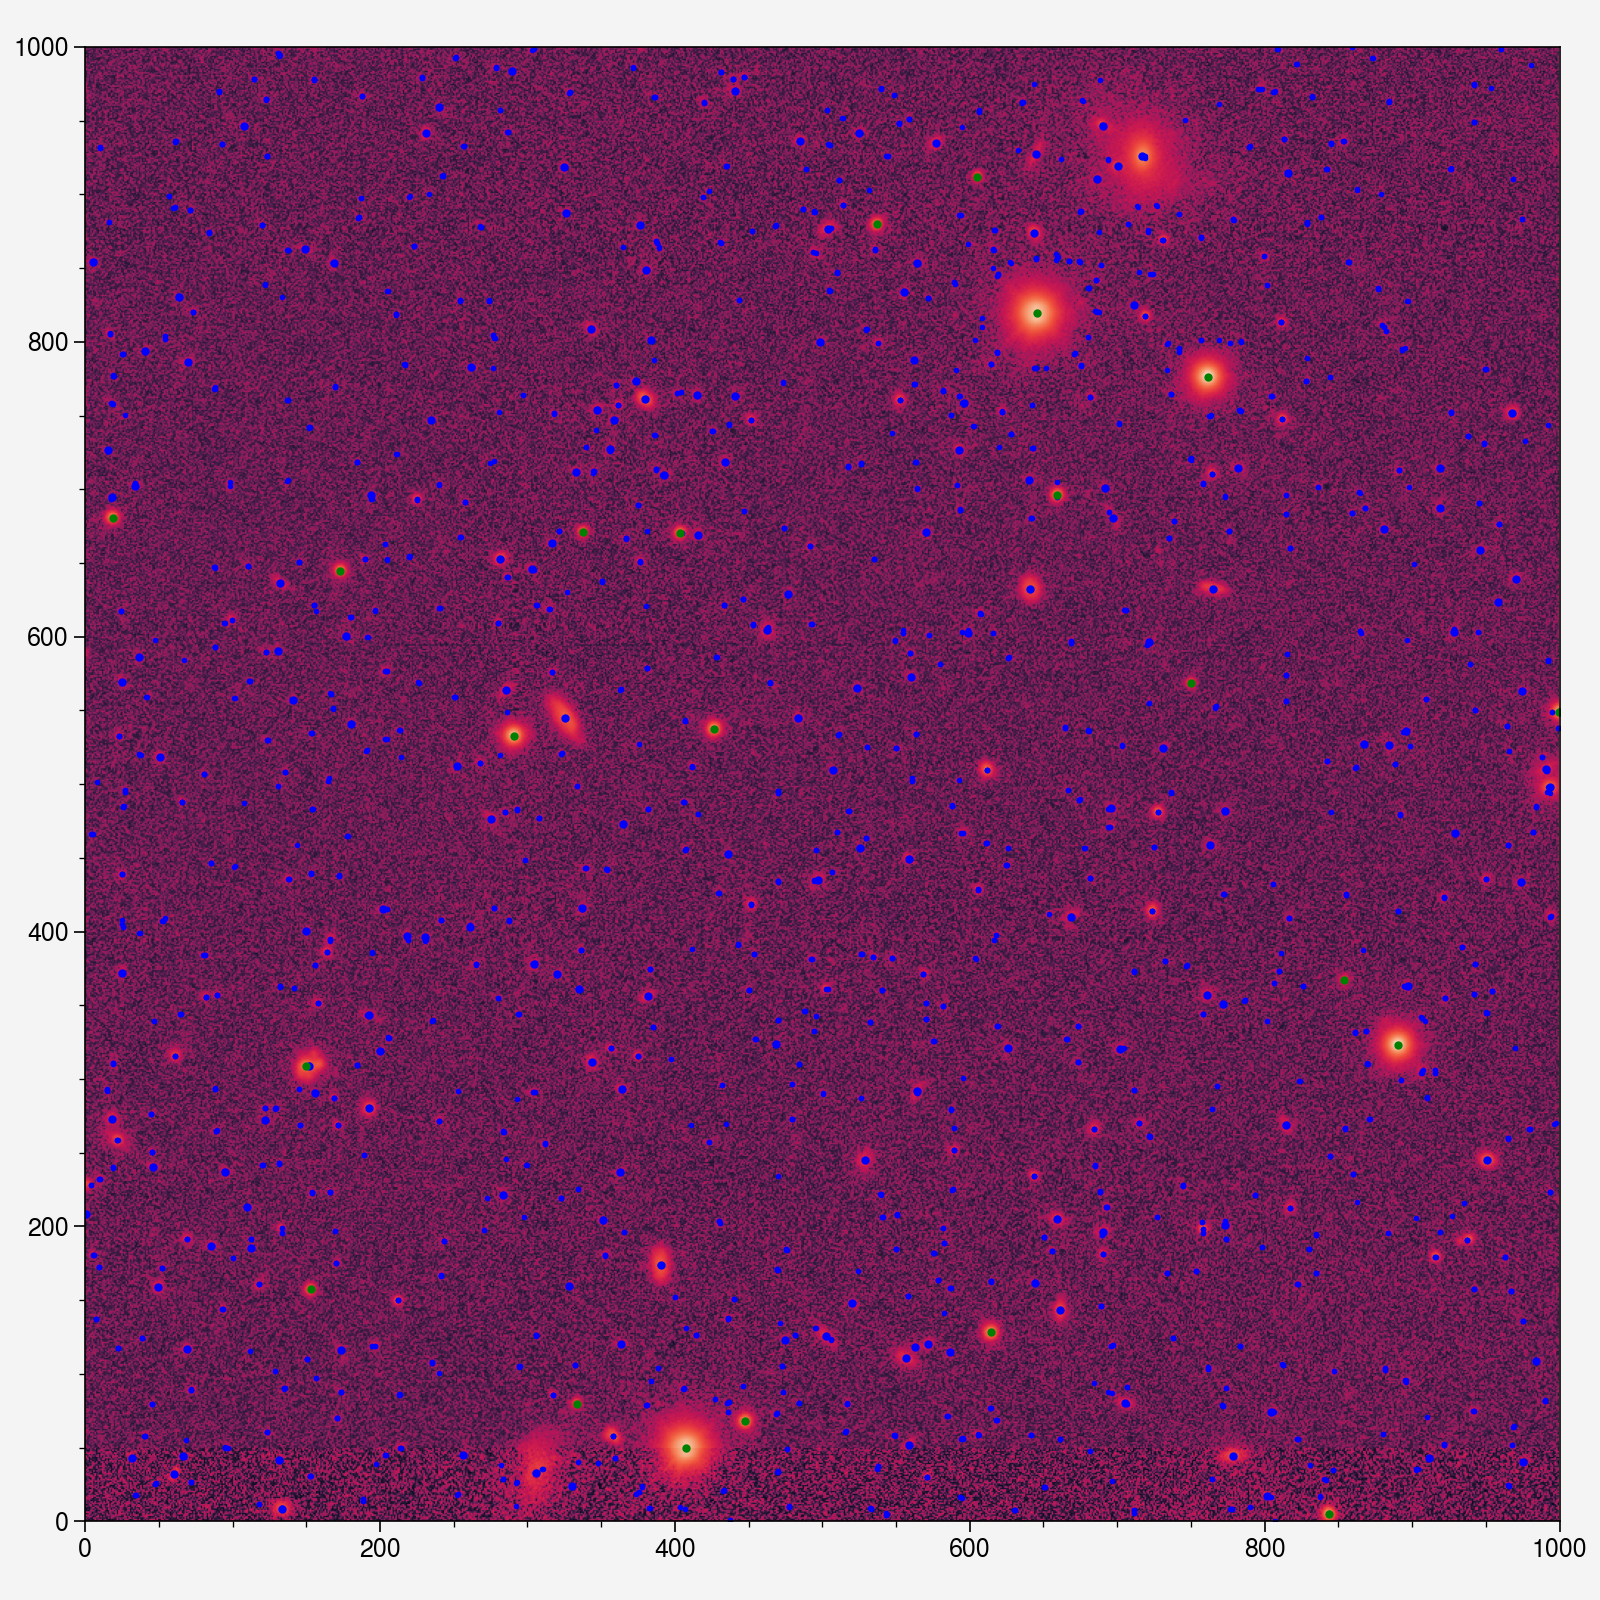

In [8]:
fig, axs = pplt.subplots(nrows=1, ncols=1, figsize=(8, 8))
L = 1000
xmin = 1000
ymin = 2000

xmax = xmin + L
ymax = ymin + L

axs.imshow(
    np.arcsinh(img[ymin:ymax, xmin:xmax]), 
    origin="lower", 
    cmap="rocket",
)

msk = (
    (d["mdet_step"] == "noshear")
    & (d["x"] >= xmin)
    & (d["x"] <= xmax)
    & (d["y"] >= ymin)
    & (d["y"] <= ymax)
)
axs.plot(d["x"][msk]-xmin, d["y"][msk]-ymin, '.', color="b", markersize=2)

msk = (
    (d["gauss_flags"] == 0)
    & (d["pgauss_flags"] == 0)
    & (d["mask_flags"] == 0)
    & (d["psfrec_flags"] == 0)
    & (d["mdet_step"] == "noshear")
    & (d["gauss_s2n"] > 10)
    & (d["gauss_T_ratio"] > 0.5)
    & (d["x"] >= xmin)
    & (d["x"] <= xmax)
    & (d["y"] >= ymin)
    & (d["y"] <= ymax)
)
axs.plot(d["x"][msk]-xmin, d["y"][msk]-ymin, '.', color="b", markersize=4)

axs.plot(gs["x"]-xmin, gs["y"]-ymin, '.', color="g", markersize=4)

axs.grid(False)

axs.set_xlim(0, L)
axs.set_ylim(0, L)

In [ ]:
def _download_tile(tilename, cwd="."):
    os.system("mkdir -p data")

    d = fitsio.read(
        os.path.join(cwd, "fnames.fits"),
        lower=True,
    )
    tnames = np.array([
        d["filename"][i].split("_")[0]
        for i in range(d.shape[0])
    ])
    msk = (tnames == tilename) & (d["band"] == "r")
    if np.sum(msk) != 1:
        return np.sum(msk)

    d = d[msk]
    mfiles = []
    for band in ["r"]:
        msk = d["band"] == band
        if np.any(msk):
            _d = d[msk]
            for i in range(len(_d)):
                fname = os.path.join(d["path"][msk][i], d["filename"][msk][i])
                if not os.path.exists("./data/%s" % os.path.basename(fname)):
                    cmd = """\
rsync \
-av \
--password-file $DES_RSYNC_PASSFILE \
${DESREMOTE_RSYNC_USER}@${DESREMOTE_RSYNC}/%s \
./data/%s
""" % (fname, os.path.basename(fname))
                    subprocess.run(cmd, shell=True, check=True)
            mfiles.append("./data/%s" % os.path.basename(fname))

    return mfiles


In [ ]:
tname = "DES0000+0209"

mfiles = _download_tile(tname)

In [ ]:
import subprocess

subprocess.run(
    "make-coadd-image-from-slices data/DES0000+0209_r5932p01_r_pizza-cutter-slices.fits.fz",
    shell=True,
    check=True,
)

In [ ]:
m = NGMixMEDS(mfiles[0])

In [ ]:
idd = np.argmin((m["orig_col"][:, 0] - 7.33e3)**2 + (m["orig_row"][:, 0] - 1.01e3)**2)
# idd = np.argmin((m["orig_col"][:, 0] - 5000.0)**2 + (m["orig_row"][:, 0] - 6000.0)**2)
# idd = 4271

obs = m.get_obs(idd, 0)

base_cfg = {

    'deblend_cont': 0.00001,

    'deblend_nthresh': 64,

    'minarea': 4,

    'filter_type': 'conv',

    # 7x7 convolution mask of a gaussian PSF with FWHM = 3.0 pixels.
    'filter_kernel':  np.array([
        [0.004963, 0.021388, 0.051328, 0.068707, 0.051328, 0.021388, 0.004963],
        [0.021388, 0.092163, 0.221178, 0.296069, 0.221178, 0.092163, 0.021388],
        [0.051328, 0.221178, 0.530797, 0.710525, 0.530797, 0.221178, 0.051328],
        [0.068707, 0.296069, 0.710525, 0.951108, 0.710525, 0.296069, 0.068707],
        [0.051328, 0.221178, 0.530797, 0.710525, 0.530797, 0.221178, 0.051328],
        [0.021388, 0.092163, 0.221178, 0.296069, 0.221178, 0.092163, 0.021388],
        [0.004963, 0.021388, 0.051328, 0.068707, 0.051328, 0.021388, 0.004963],
    ]),
}

cfg = copy.deepcopy(base_cfg)
cfg["deblend_cont"] = 0.00001
cat, _ = sxdes.run_sep(
    obs.image.copy(), 
    1.0/np.sqrt(obs.weight).copy(), 
    config=cfg,
)

cfg = copy.deepcopy(base_cfg)
cfg["deblend_cont"] = 0.001
cat_des, _ = sxdes.run_sep(
    obs.image.copy(), 
    1.0/np.sqrt(obs.weight).copy(), 
    config=cfg,
)

fig, axs = pplt.subplots(nrows=1, ncols=2, figsize=(4, 2))

axs[0].imshow(
    np.arcsinh(obs.image*np.sqrt(obs.weight)), 
    origin="lower",
    cmap="rocket",
)
axs[0].plot(cat["x"], cat["y"], ".b")
axs[0].format(title="mdet")

axs[1].imshow(
    np.arcsinh(obs.image*np.sqrt(obs.weight)), 
    origin="lower",
    cmap="rocket",
)
axs[1].plot(cat_des["x"], cat_des["y"], ".b")
axs[1].format(title="Y6A2")

In [ ]:
r2 = (m["orig_col"][:, 0] - 1500.0)**2 + (m["orig_row"][:, 0] - 4400.0)**2

In [ ]:
m["id"][np.argmin(r2)]

In [ ]:
m["orig_col"]